# Load data

In [1]:
import re
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as K
import keras_tuner as kt

from utils import normalize_mid_points, read_data

In [2]:
keypoints = os.listdir('../data/keypoints')

# punch types: hook, jab, uper
keypoints_by_punch_types = [
    [i for i in keypoints if 'hook' in i],
    [i for i in keypoints if 'jab' in i],
    [i for i in keypoints if 'uper' in i]
]

In [3]:
keypoints_by_punch_types

[['id4_hook_1.npy',
  'id1_hook_2.npy',
  'id0_hook_2_reversed.npy',
  'id0_hook_2.npy',
  'id4_hook_2.npy',
  'id1_hook_2_reversed.npy',
  'id2_hook_2.npy',
  'id3_hook_1.npy',
  'id1_hook_1.npy',
  'id3_hook_2.npy',
  'id4_hook_2_reversed.npy',
  'id0_hook_1.npy',
  'id2_hook_1.npy',
  'id3_hook_2_reversed.npy',
  'id2_hook_2_reversed.npy'],
 ['id0_jab_2.npy',
  'id0_jab_1.npy',
  'id4_jab_2.npy',
  'id4_jab_2_reversed.npy',
  'id4_jab_1.npy',
  'id0_jab_2_reversed.npy',
  'id2_jab_2.npy',
  'id1_jab_2_reversed.npy',
  'id3_jab_1.npy',
  'id1_jab_1.npy',
  'id2_jab_2_reversed.npy',
  'id3_jab_2_reversed.npy',
  'id2_jab_1.npy',
  'id1_jab_2.npy',
  'id3_jab_2.npy'],
 ['id2_uper_1.npy',
  'id4_uper_2.npy',
  'id3_uper_2.npy',
  'id4_uper_1.npy',
  'id4_uper_2_reversed.npy',
  'id1_uper_2.npy',
  'id2_uper_2.npy',
  'id0_uper_2.npy',
  'id0_uper_2_reversed.npy',
  'id3_uper_2_reversed.npy',
  'id0_uper_1.npy',
  'id2_uper_2_reversed.npy',
  'id1_uper_2_reversed.npy',
  'id1_uper_1.npy'

In [4]:
X_train_list = []
y_train_list = []
X_val_list = []
y_val_list = []

for keypoints in keypoints_by_punch_types:
    test_keypoints = random.choice(keypoints)

    for label in [i for i in keypoints if i != test_keypoints]:
        X, y = read_data(label, skip_midpoints=False)
        X_train_list.append(X)
        y_train_list.append(y)
    
    X, y = read_data(test_keypoints, skip_midpoints=False)
    X_val_list.append(X)
    y_val_list.append(y)


X_train = np.concatenate(X_train_list)
y_train = np.concatenate(y_train_list)
X_val = np.concatenate(X_val_list)
y_val = np.concatenate(y_val_list)

In [5]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((44136, 36), (44136,), (2247, 36), (2247,))

In [6]:
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

def format_feature_names(names, skip_midpoints=False, ndims=3):
    feature_names = []
    for name in list(KEYPOINT_DICT.keys()):
        feature_names.append(name+'-x')
        feature_names.append(name+'-y')
        if ndims==3:
            feature_names.append(name+'-z')
    feature_names.append('mid_point-x')
    feature_names.append('mid_point-y')
    if ndims==3:
        feature_names.append('mid_point-z')
    return feature_names



feature_names = format_feature_names(list(KEYPOINT_DICT.keys()), ndims=2, skip_midpoints=False)

In [7]:
df = pd.DataFrame(data=X_train, columns=feature_names)

In [8]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
nose-x,44136.0,-0.219221,0.029118,-0.464482,-0.236093,-0.216671,-0.200788,0.361919
nose-y,44136.0,-0.050073,0.143987,-0.668847,-0.166915,-0.102941,0.098393,0.475557
left_eye-x,44136.0,-0.231098,0.030527,-0.394743,-0.249125,-0.228599,-0.212201,0.359797
left_eye-y,44136.0,-0.050502,0.141363,-0.627711,-0.167588,-0.100606,0.091307,0.477576
right_eye-x,44136.0,-0.231914,0.030643,-0.407856,-0.250418,-0.228974,-0.212691,0.359336
right_eye-y,44136.0,-0.045027,0.139973,-0.669672,-0.155327,-0.093193,0.095142,0.475477
left_ear-x,44136.0,-0.233788,0.030106,-0.474184,-0.253674,-0.231836,-0.214006,0.366997
left_ear-y,44136.0,-0.038051,0.105158,-0.630786,-0.128724,-0.055390,0.046733,0.474723
right_ear-x,44136.0,-0.235984,0.030840,-0.469636,-0.256027,-0.233489,-0.215368,0.363357
right_ear-y,44136.0,-0.022213,0.101830,-0.600944,-0.093479,-0.043380,0.053306,0.473494


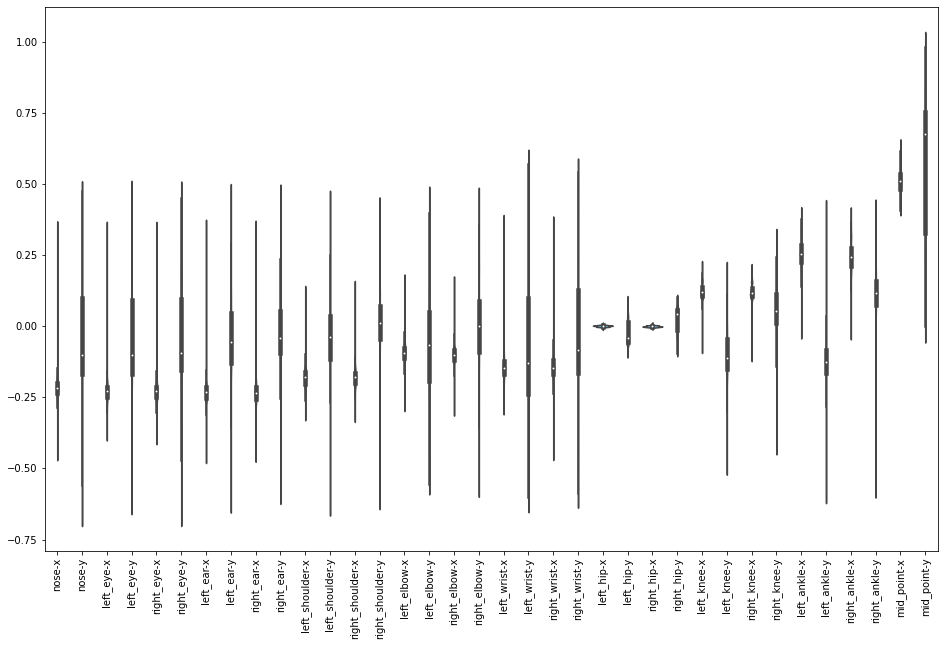

In [9]:
plt.figure(figsize=(16, 10))
ax = sns.violinplot(data=df)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [10]:
time_steps=30 # expect camera 30 fps, so process 1 sample per second
# Number of samples in batch
N_train = X_train.shape[0] // time_steps 
N_val = X_val.shape[0] // time_steps

X_train = X_train[:N_train*time_steps].reshape(-1, time_steps, 36)
y_train = y_train[:N_train*time_steps].reshape(-1, time_steps, 1)
X_val = X_val[:N_val*time_steps].reshape(-1, time_steps, 36)
y_val = y_val[:N_val*time_steps].reshape(-1, time_steps, 1)
X_train.shape, X_val.shape

((1471, 30, 36), (74, 30, 36))

## GRU

In [11]:
y_train = K.utils.to_categorical(y_train, num_classes=7)
X_train = tf.constant(X_train)
y_val = K.utils.to_categorical(y_val, num_classes=7)
X_val = tf.constant(X_val)

In [12]:
def model_builder(hp):
    # Hyperparams
    hp_ru = hp.Int('recurrent_units', min_value=16, max_value=128, step=8)
    hp_du1 = hp.Int('units1', min_value=16, max_value=128, step=8)
    hp_du2 = hp.Int('units2', min_value=16, max_value=128, step=8)
    hp_reg1 = hp.Float('dense1_reg', min_value=1e-4, max_value=1e-2)
    hp_reg2 = hp.Float('dense2_reg', min_value=1e-4, max_value=1e-2)
    
    hp_dp = hp.Float('dropout', min_value=0., max_value=0.4)
    hp_rec_dp = hp.Float('rec_dropout', min_value=0., max_value=0.4)
    hp_kernel_reg = hp.Float('kernel_reg', min_value=1e-5, max_value=1e-3, sampling='log')
    hp_recur_reg = hp.Float('recur_reg', min_value=1e-5, max_value=1e-3, sampling='log')
    hp_act_reg = hp.Float('act_reg', min_value=1e-5, max_value=1e-3, sampling='log')
    
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2)

    
    # Model
    norm = tf.keras.layers.LayerNormalization(axis=1)
    kernel_reg = K.regularizers.l2(hp_kernel_reg)
    recurrent_reg = K.regularizers.l2(hp_recur_reg)
    act_reg = K.regularizers.l2(hp_act_reg)
    lstm = K.layers.GRU(hp_ru,
                         # stateful=True, # mutable states not supported in tflite 
                         return_sequences=True,
                         kernel_regularizer=kernel_reg,
                         recurrent_regularizer=recurrent_reg,
                         activity_regularizer=act_reg,
                         dropout=hp_dp,
                         recurrent_dropout=hp_rec_dp
                        )
    dense1 = K.layers.Dense(hp_du1, activation='relu', 
                            kernel_regularizer=K.regularizers.l2(hp_reg1))
    dense2 = K.layers.Dense(hp_du2, activation='relu', 
                           kernel_regularizer=K.regularizers.l2(hp_reg2))
    out = K.layers.Dense(7, activation='sigmoid')

    model = K.Sequential([norm, lstm, dense1, dense2, out])
    model.compile(optimizer=K.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [22]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=20,
                     directory='kt_dir2',
                     project_name='punch_dl_kt')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)

tuner.search(X_train, y_train, batch_size=1, validation_data=(X_val, y_val), 
             epochs=32, callbacks=[stop_early])

Trial 30 Complete [00h 05m 23s]
val_accuracy: 0.7681481242179871

Best val_accuracy So Far: 0.7681481242179871
Total elapsed time: 00h 51m 43s
INFO:tensorflow:Oracle triggered exit


In [23]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

best_hps.values

{'recurrent_units': 56,
 'units1': 32,
 'units2': 96,
 'dense1_reg': 0.006817485637491699,
 'dense2_reg': 0.00016585630919108894,
 'dropout': 0.17004063934808059,
 'rec_dropout': 0.2930442767252661,
 'kernel_reg': 0.0002442564618246685,
 'recur_reg': 0.00018324337625857988,
 'act_reg': 0.0001903660088901338,
 'learning_rate': 0.004141116129744336,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [27]:
# Build the model with the optimal hyperparameters and train it on the data for 64 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, batch_size=1, 
                    validation_data=(X_val, y_val), 
                    epochs=64,
                   callbacks=[K.callbacks.ReduceLROnPlateau()])

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/64
1455/1455 [==============================] - 16s 10ms/step - loss: 1.2964 - accuracy: 0.5696 - val_loss: 1.0859 - val_accuracy: 0.6081
Epoch 2/64
1455/1455 [==============================] - 13s 9ms/step - loss: 1.1284 - accuracy: 0.6086 - val_loss: 1.1019 - val_accuracy: 0.6741
Epoch 3/64
1455/1455 [==============================] - 13s 9ms/step - loss: 1.0722 - accuracy: 0.6276 - val_loss: 1.0090 - val_accuracy: 0.6507
Epoch 4/64
1455/1455 [==============================] - 13s 9ms/step - loss: 1.0414 - accuracy: 0.6447 - val_loss: 1.0307 - val_accuracy: 0.6711
Epoch 5/64
1455/1455 [==============================] - 13s 9ms/step - loss: 1.0171 - accuracy: 0.6566 - val_loss: 1.2471 - val_accuracy: 0.5956
Epoch 6/64
1455/1455 [==============================] - 13s 9ms/step - loss: 0.9823 - accuracy: 0.6697 - val_loss: 0.9830 - val_accuracy: 0.7137
Epoch 7/64
1455/1455 [==============================] - 13s 9ms/step - loss: 0.9656 - accuracy: 0.6799 - val_loss: 1.0159 - val_a

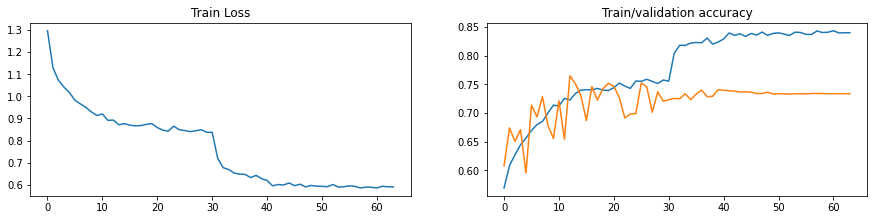

In [28]:
plt.figure(figsize=(15, 7))
plt.subplot(221)
plt.title("Train Loss")
plt.plot(history.history['loss'])
plt.subplot(222)
plt.title("Train/validation accuracy")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [30]:
model.save('../models/GRU-Normalized-Stream-01')

INFO:tensorflow:Assets written to: ../models/GRU-Normalized-Stream-01/assets


## Conclusion 

We need more data to avoid overfitting

# Moving with k-nearest

In [47]:
y_pred = np.argmax(model(X_val).numpy(), axis=-1).ravel()
y_val_np = np.concatenate(y_val_list)[:N_val*time_steps]

In [48]:
# [1,1,1,1,3,3,1,1] -> [1]
# moving window across padded y_pred
# output element is most frequent in window

win_size = time_steps // 2
mf_smooth = np.zeros(y_pred.shape[0]+win_size)
for i in range(len(y_pred) - win_size):
    window = y_pred[i:i+win_size]
    bins = np.bincount(window)
    mf_smooth[i+win_size//2] = np.argmax(bins)

mf_smooth = mf_smooth[:-win_size]

In [49]:
len(mf_smooth), len(y_pred), len(y_val_np)

(2700, 2700, 2700)

In [50]:
print(np.mean(y_val_np==y_pred))
print(np.mean(y_val_np==mf_smooth))

0.7337037037037037
0.7366666666666667


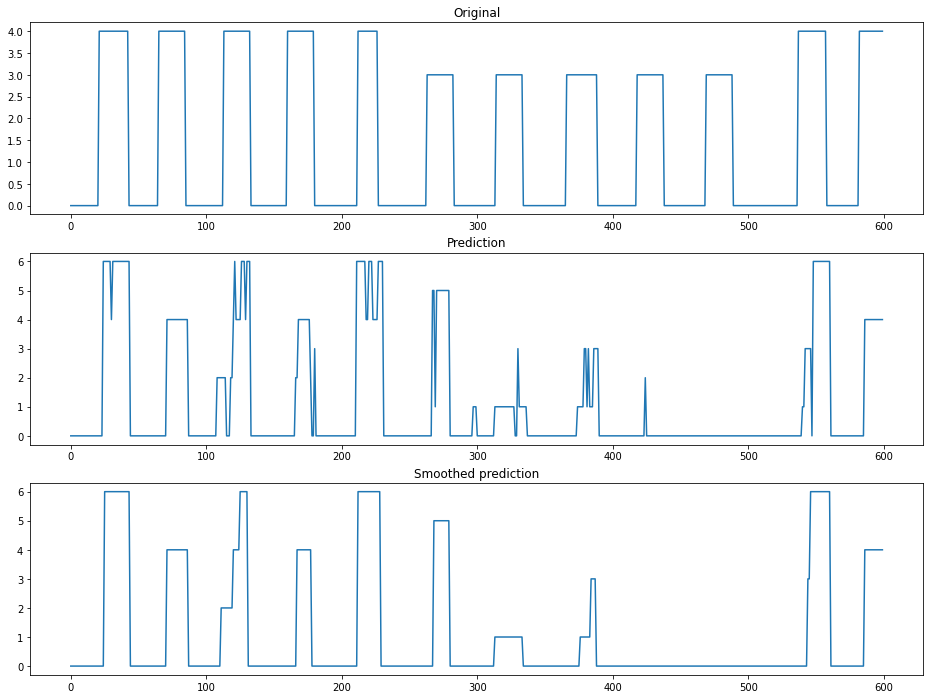

In [51]:
plt.figure(figsize=(16, 12))

plt.subplot(3, 1, 1)
plt.title('Original')
plt.plot(y_val_np[:600])

plt.subplot(3, 1, 2)
plt.title('Prediction')
plt.plot(y_pred[:600])

plt.subplot(3, 1, 3)
plt.title('Smoothed prediction')
plt.plot(mf_smooth[:600])


Thanks to:  
https://github.com/keras-team/keras-tuner